In [10]:
import torch
from torch import nn
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision

# Defined datasets and dataloaders
##### - we first set some transforms for batch normalization of data

In [11]:
# first we initialize transforms for data.
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
          (0.2470, 0.2435, 0.2616)),
])


# train data pack:
train_data = datasets.CIFAR10(
# write the directory of your datas
    root='F:\KOSOSHER\my-shits-in-ai\data',
    train=True,
    transform=transforms,
    download=True,
)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)


# test data pack:
test_data = datasets.CIFAR10(
# write the directory of your datas
    root='F:\KOSOSHER\my-shits-in-ai\data',
    train=False,
    transform=transforms,
    download=True,
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

<>:12: SyntaxWarning: invalid escape sequence '\K'
<>:23: SyntaxWarning: invalid escape sequence '\K'
<>:12: SyntaxWarning: invalid escape sequence '\K'
<>:23: SyntaxWarning: invalid escape sequence '\K'
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13840\2557845043.py:12: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',
C:\Users\ahmad\AppData\Local\Temp\ipykernel_13840\2557845043.py:23: SyntaxWarning: invalid escape sequence '\K'
  root='F:\KOSOSHER\my-shits-in-ai\data',


# Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


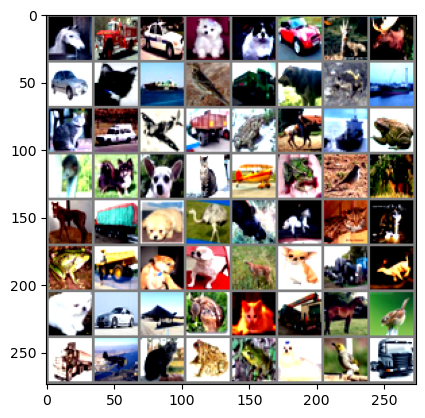

In [13]:
# Visualizing :
batch_size = 10

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
# images, labels = dataiter.next()
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Define The Neural Network

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.stack = nn.Sequential(
            # Convolutional Network
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Flatting the data
            nn.Flatten(),

            # Fully Connected Network
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        logits = self.stack(x)
        return logits

# Define a device and optimizer and loss function (criterion)

In [ ]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

Using cpu device


In [ ]:
model = NeuralNetwork().to(device)

In [ ]:
optim = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = CrossEntropyLoss()

# Define function for training

In [ ]:
def train_set(model, train_dataloader, optim, criterion):
    running_loss, correct = 0.0, 0
    model.train()

    for x, y in train_dataloader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad() # reset the current grads
        y_pred = model(x) # calculate the predicted model
        loss = criterion(y_pred, y) # calculate the loss
        loss.backward() # perform backpropagation
        optim.step() # set up the updated weights
        running_loss += loss.item()
        correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    return running_loss / len(train_dataloader), (correct / len(train_dataloader.dataset)) * 100

# time to train datas.

In [ ]:
def train_model(model, train_dataloader, test_dataloader, optim, criterion, epochs):
    train_losses, train_accs = [], []
    for epoch in range(epochs):
        train_loss, train_acc = train_set(model, train_dataloader, optim, criterion)
        # test_loss, test_acc = test_set(model, test_dataloader, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # test_losses.append(test_loss)
        # test_accs.append(test_acc)
        print(f"Epoch: {epoch+1} / {epochs} => Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    return train_losses, train_accs

#### now we have writed a function to train the model on training datas; if the results were good enough and we were certain of it, we are allowed to use test datas to see if our model fitted well on the dataset.

# Function for test data.

In [ ]:
def test_set(model, test_dataloader, criterion):
    running_loss, correct = 0.0, 0
    model.eval()
    with torch.no_grad(): # disable gradients because its test case
        for x, y in test_dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            running_loss += loss.item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(test_dataloader), (correct / len(test_dataloader.dataset)) * 100


# Final Evaluation

In [ ]:
def test_model(model, test_dataloader, criterion):
    test_losses, test_accs = [], []
    test_loss, test_acc = test_set(model, test_dataloader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    return test_loss, test_acc

In [22]:
history = train_data(model, optim, device, criterion, train_dataloader, 8)

Epoch 1 / 8 => loss : 1.629 ; accuracy : 40.012 
Epoch 2 / 8 => loss : 1.547 ; accuracy : 43.538 
Epoch 3 / 8 => loss : 1.681 ; accuracy : 37.944 
Epoch 4 / 8 => loss : 2.130 ; accuracy : 18.848 
Epoch 5 / 8 => loss : 2.312 ; accuracy : 10.086 
Epoch 6 / 8 => loss : 2.310 ; accuracy : 9.936 
Epoch 7 / 8 => loss : 2.310 ; accuracy : 9.954 
